In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

In [2]:
from tqdm.notebook import tqdm

In [3]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [154]:
loaded = False

# Load BioBank Components

In [156]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 478 features.
UK BioBank Data Loaded.
Size: 502536 rows x 478 columns
Elapsed time: 65.1435 seconds


Mapping Medical Codes:   0%|          | 0/448 [00:00<?, ? feature/s]

# All illnesses

In [157]:
data = biobank_data.sample(10000) if len(biobank_data) > 10000 else biobank_data

In [158]:
illness_codes = [feature for feature in biobank_data.columns if get_base_feature(feature) == "illness_code"]
all_illnesses = biobank_data[illness_codes].values.ravel()
all_illnesses, counts = np.unique(all_illnesses[~pd.isnull(all_illnesses)], return_counts=True)

In [159]:
illness_dict = {}
for illness in tqdm(all_illnesses):
    illness_dict[illness] = get_illness_value(data, illness, "illness_code")

  0%|          | 0/444 [00:00<?, ?it/s]

In [160]:
illness_data = pd.concat([data[["eid", "sex", "birth_year"]], pd.DataFrame(illness_dict)], axis=1)

In [161]:
illness_graph = np.zeros((len(all_illnesses), len(all_illnesses)))

In [162]:
for i, illness in enumerate(all_illnesses):
    illness_values = illness_data[illness].values
    for j, associated_illness in enumerate(all_illnesses):
        illness_graph[i, j] = np.count_nonzero(illness_values & illness_data[associated_illness].values)

In [163]:
unique_edge_weights = illness_graph[np.triu_indices(len(illness_graph))]
unique_edge_weights = unique_edge_weights[unique_edge_weights != 0]

C:\Users\Cole\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Cole\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Cole\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Cole\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Suppor

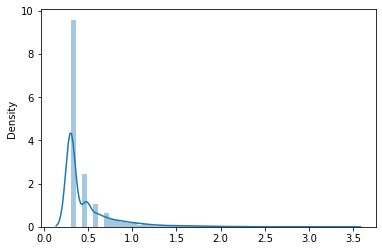

In [164]:
sns.distplot(np.log10(unique_edge_weights + 1))

In [165]:
df = pd.DataFrame(illness_graph, columns=all_illnesses)
df.index = all_illnesses
df

,abdominal hernia,abnormal smear (cervix),acne/acne vulgaris,acromegaly,acute infective polyneuritis/guillain-barre syndrome,adrenal tumour,adrenocortical insufficiency/addison's disease,alcohol dependency,alcoholic liver disease / alcoholic cirrhosis,allergy or anaphylactic reaction to drug,...,varicose veins,vasculitis,venous thromboembolic disease,vertigo,vitiligo,vocal cord polyp,wegners granulmatosis,whooping cough / pertussis,wolff parkinson white / wpw syndrome,yellow fever
abdominal hernia,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abnormal smear (cervix),0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
acne/acne vulgaris,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acromegaly,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acute infective polyneuritis/guillain-barre syndrome,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal cord polyp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
wegners granulmatosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
whooping cough / pertussis,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
wolff parkinson white / wpw syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


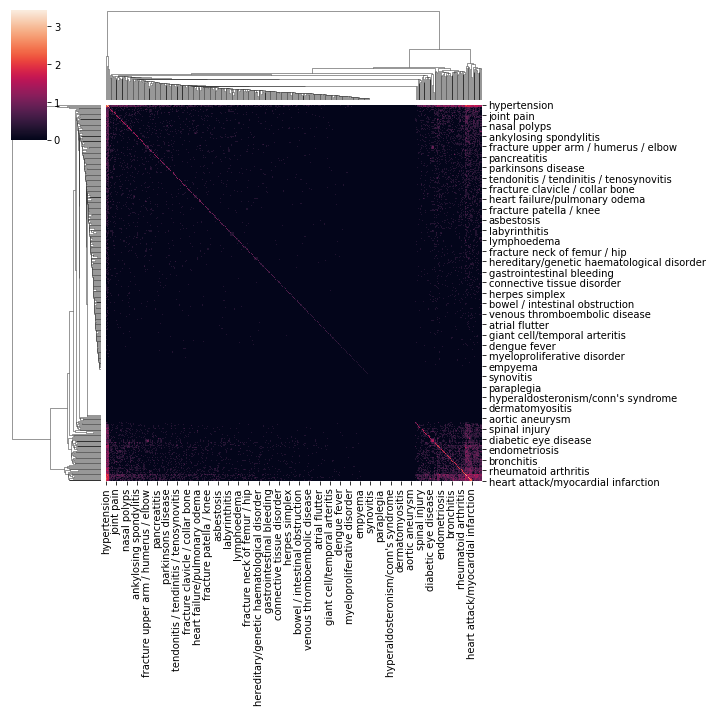

In [166]:
sns.clustermap(np.log10(df + 1))

In [167]:
from analysis import *

In [168]:
['b12 - hydroxocobalamin prep', 'vitamin b12 preparation', 
 'b12 - cyanocobalamin prep', 'hepacon b12 1mg/1ml injection', 'feroglobin b12 syrup']

['b12 - hydroxocobalamin prep',
 'vitamin b12 preparation',
 'b12 - cyanocobalamin prep',
 'hepacon b12 1mg/1ml injection',
 'feroglobin b12 syrup']

In [170]:
recieved_B12 = get_illness_value(biobank_data, 'b12', "treatment_code", fuzzy=True)
recieved_D3 = get_illness_value(biobank_data, 'd3', "treatment_code", fuzzy=True)
recieved_vitamin = get_illness_value(biobank_data, 'vitamin', "treatment_code", fuzzy=True)

In [203]:
father_depression = get_illness_value(biobank_data, 'severe depression', "father_illnesses")
print(variable_OR_test(illness_values, father_depression, variable_name="Father depression"))

mother_depression = get_illness_value(biobank_data, 'severe depression', "mother_illnesses")
print(variable_OR_test(illness_values, mother_depression, variable_name="mother depression"))

Father depression == True: OR: 1.161 p-value: 0.232 95% CI: 0.95 - 1.42 N: 68

mother depression == True: OR: 0.910 p-value: 0.400 95% CI: 0.77 - 1.08 N: 100



In [201]:
print(illness)
print(variable_OR_test(illness_values, recieved_B12, variable_name="recieved B12"))
print(variable_OR_test(illness_values, recieved_D3, variable_name="recieved D3"))
print(variable_OR_test(illness_values, recieved_vitamin, variable_name="recieved vitamin"))
print(variable_OR_test(illness_values, recieved_B12 | recieved_D3, variable_name="recieved D3 or B12"))
print(variable_OR_test(illness_values, recieved_B12 & recieved_D3, variable_name="recieved D3 and B12"))

multiple sclerosis
recieved B12 == True: OR: 6.357 p-value: 6.1e-23 95% CI: 5.00 - 8.09 N: 49 ***

recieved D3 == True: OR: 2.724 p-value: 2.6e-14 95% CI: 2.25 - 3.29 N: 80 ***

recieved vitamin == True: OR: 1.896 p-value: 2e-16 95% CI: 1.68 - 2.13 N: 222 ***

recieved D3 or B12 == True: OR: 3.467 p-value: 1.7e-29 95% CI: 2.97 - 4.04 N: 124 ***

recieved D3 and B12 == True: OR: 10.259 p-value: 0.000 95% CI: 4.85 - 21.72 N: 5 ***



R: 0.444  P-value: 0.00393
Mean years before: -2.4
Median years before: -2.0
depression == True: OR: 1.584 p-value: 3.9e-07 95% CI: 1.38 - 1.82 N: 150 ***



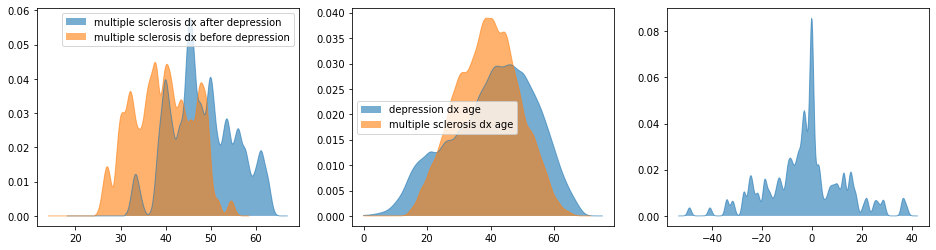

In [199]:
precursor_illness = "depression"
illness = "multiple sclerosis"

_, precursor_dx_ages = get_illness_value_dx_age(biobank_data, precursor_illness, "illness_code")
_, illness_dx_ages = get_illness_value_dx_age(biobank_data, illness, "illness_code")

precursor_before_illness = illness_dx_ages > precursor_dx_ages
precursor_values, illness_values = precursor_dx_ages >= 0, illness_dx_ages >= 0

fig, (a0, a1, a2) = plt.subplots(figsize=(16, 4), ncols=3)
params = dict(bw=0.1, clip=(0, None))
kde_plot(illness_dx_ages[precursor_values & precursor_before_illness],
         label=f"{illness} dx after {precursor_illness}", ax=a0, **params)
kde_plot(illness_dx_ages[precursor_values & ~precursor_before_illness & illness_values],
         label=f"{illness} dx before {precursor_illness}", ax=a0, **params)
kde_plot(precursor_dx_ages[precursor_values], label=f"{precursor_illness} dx age", ax=a1, **params)
kde_plot(illness_dx_ages[illness_values], label=f"{illness} dx age", ax=a1, **params)
years_before_dx = (illness_dx_ages - precursor_dx_ages)[precursor_values & illness_values]
kde_plot(years_before_dx, bw=.05, ax=a2)

r, p = preceding_event_test(precursor_dx_ages, illness_dx_ages)
print(f"R: {r:.3}  P-value: {p:.3}")
print(f"Mean years before: {np.mean(years_before_dx):.2}")
print(f"Median years before: {np.median(years_before_dx):.2}")
print(variable_OR_test(illness_values, precursor_values, variable_name=f"{precursor_illness}"))

In [18]:
np.random.seed(6)
some_illnesses_raw = sorted(np.random.choice(all_illnesses, 20))
some_illnesses_raw = all_illnesses

illness_dx_data = {}
for illness in tqdm(some_illnesses_raw, desc="Aggregating illness dates", unit=" illnesses"):
    new_illness_label = illness.replace(" ", "_")
    _, illness_dx_age = get_illness_value_dx_age(biobank_data, illness, "illness_code")
    illness_dx_data[new_illness_label] = illness_dx_age

illness_dx_data = pd.DataFrame(illness_dx_data)
some_illnesses = list(illness_dx_data.columns)

Aggregating illness dates: 100%|██████████| 444/444 [01:16<00:00,  5.84 illnesses/s]


In [24]:
np.random.seed(6)
some_illnesses = sorted(np.random.choice(list(illness_dx_data.columns), 100, replace=False))
# some_illnesses = list(illness_dx_data.columns)

In [25]:
from tqdm.notebook import tqdm

In [26]:
# Precomputing age distributions
params = dict(min_value=-1, max_value=110, n_sample=1000, force_kde=True)

distributions = {}
for illness in tqdm(some_illnesses, unit=" illnesses", desc="Precomputing age distributions"):
    illness_dx_ages = illness_dx_data[illness].values
    illness_values = illness_dx_ages >= 0
    _, y_probs = create_sampled_distribution(illness_dx_ages[illness_values], **params)
    distributions[illness] = (y_probs, illness_values)

preceding_event_values = []

# comparing all illness age distributions
pbar = tqdm(total=len(some_illnesses) ** 2, unit=" illnesses", desc="Identifying preceding illnesses")
for illness in some_illnesses:
    illness_preceding_tests = []
    for precursor_illness in some_illnesses:
        if precursor_illness == illness:
            illness_preceding_tests.append([np.nan, 0, 0, 0])
        else:

            precursor_dx_ages, illness_dx_ages = illness_dx_data[precursor_illness].values, illness_dx_data[illness].values

            illness_dist, illness_values = distributions[illness]
            precursor_dist, precursor_values = distributions[precursor_illness]
            illness_and_infection = precursor_values & illness_values
                
            n_with_illness_and_infection = np.count_nonzero(illness_and_infection)
            precedes = illness_dx_ages > precursor_dx_ages
            n_with_illness_and_prior_infection = np.count_nonzero(illness_and_infection & precedes)
            p = np.sum(np.append([0], np.cumsum(precursor_dist))[:-1] * illness_dist)

            if n_with_illness_and_infection <= 4:
                illness_preceding_tests.append([np.nan, 0, 0, 0])
            else:
                results = stats.binomtest(n_with_illness_and_prior_infection, n_with_illness_and_infection,
                                          p=p, alternative="greater")
                illness_preceding_tests.append([results.pvalue, n_with_illness_and_prior_infection,
                                            n_with_illness_and_infection, p])

        pbar.update(1)

    preceding_event_values.append(illness_preceding_tests)
pbar.close()

# preceding_tests = pd.DataFrame(preceding_tests, columns=some_illnesses)
# preceding_tests.index = some_illnesses

Precomputing age distributions:   0%|          | 0/100 [00:00<?, ? illnesses/s]

Identifying preceding illnesses:   0%|          | 0/10000 [00:00<?, ? illnesses/s]

In [27]:
preceding_event_values = np.array(preceding_event_values)
data_keys = ["pvalue", "n_with_preceding", "n_with_both", ]
preceding_events_data = {key: preceding_event_values[:, :, i] for i, key in enumerate(data_keys)}
preceding_events_data["all"] = preceding_event_values
preceding_events_data["columns"] = np.array(some_illnesses)
preceding_events_data["rows"] = np.array(some_illnesses)

p_value_significance_threshold = 0.01

significant_values = preceding_event_values[:, :, 0] <= p_value_significance_threshold
row_index, col_index = np.any(significant_values, axis=1), np.any(significant_values, axis=0)

all_significant_events = preceding_event_values[row_index][:, col_index]
significant_events_data = {key: all_significant_events[:, :, i] for i, key in enumerate(data_keys)}
significant_events_data["all"] = all_significant_events
significant_events_data["columns"] = np.array(some_illnesses)[col_index]
significant_events_data["rows"] = np.array(some_illnesses)[row_index]

In [28]:
significant_events_data["pvalue"].shape

(15, 13)

In [29]:
print(stats.binomtest(6, 6, p=.75, alternative="greater"))
print(stats.binomtest(6, 6, p=.75, alternative="less"))
print(stats.binomtest(6, 6, p=.75, alternative="two-sided"))

BinomTestResult(k=6, n=6, alternative='greater', proportion_estimate=1.0, pvalue=0.17797851562500003)
BinomTestResult(k=6, n=6, alternative='less', proportion_estimate=1.0, pvalue=1.0)
BinomTestResult(k=6, n=6, alternative='two-sided', proportion_estimate=1.0, pvalue=0.347412109375)


# Preceding Event Graph

In [30]:
G = np.zeros_like(significant_events_data["pvalue"])
edge_list = []

for j, preceding_illness in enumerate(significant_events_data["columns"]):
    for i, illness in enumerate(significant_events_data["rows"]):
        if significant_events_data["pvalue"][i, j] < p_value_significance_threshold:
            G[i, j] = 1 / (significant_events_data["n_with_preceding"][i, j] / significant_events_data["n_with_both"][i, j])
#             print(preceding_illness, " -> ",  illness, significant_events_data["all"][i, j])
            edge_list.append([preceding_illness, illness, "Undirected", G[i, j]])
edge_list = pd.DataFrame(edge_list, columns = ["source", "target", "type", "weight"])

In [31]:
import networkx as nx
g = nx.from_pandas_edgelist(edge_list, source="source", target="target", edge_attr="weight")

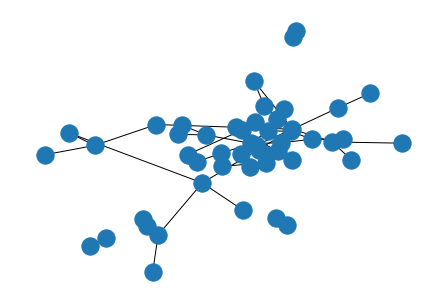

In [32]:
# nx.draw(g, pos=nx.circular_layout(g))
nx.draw(g, pos=nx.draw_kamada_kawai(g),  arrowstyle='fancy')

In [33]:
import pyvis.network as nt
net = nt.Network(notebook=True, directed=True)

net.from_nx(g)
net.show("illness_EDA_plots/example.html")

Text(879.3749999999999, 0.5, 'Illness')

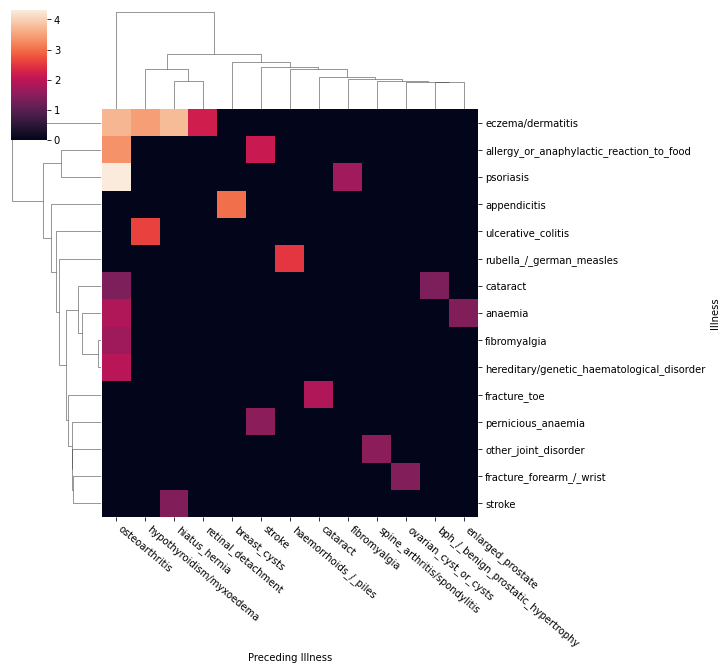

In [34]:
df = pd.DataFrame(G, columns=significant_events_data["columns"])
df.index = significant_events_data["rows"]

g = sns.clustermap(df)
ax = g.ax_heatmap
plt.setp(ax.get_xticklabels(), rotation=320, ha="left")
ax.set_xlabel("Preceding Illness")
ax.set_ylabel("Illness")

In [35]:
p_value_threshold = 0.01
df = pd.DataFrame(preceding_events_data["pvalue"], columns=preceding_events_data["columns"])
df.index = preceding_events_data["rows"]
significant = df.loc[df.lt(p_value_threshold).any(axis=1), df.lt(p_value_threshold).any()]
significant

,bph_/_benign_prostatic_hypertrophy,breast_cysts,cataract,enlarged_prostate,fibromyalgia,haemorrhoids_/_piles,hiatus_hernia,hypothyroidism/myxoedema,osteoarthritis,ovarian_cyst_or_cysts,retinal_detachment,spine_arthritis/spondylitis,stroke
allergy_or_anaphylactic_reaction_to_food,NaN,0.123357,0.367654,0.144629,NaN,NaN,0.021471,0.022218,2.500112e-03,0.570901,0.327687,0.440821,0.005575
anaemia,NaN,NaN,0.114584,0.006199,NaN,0.929596,0.218249,0.164832,1.133327e-03,0.888071,0.830788,0.139735,0.078824
appendicitis,0.478672,0.006338,0.391747,0.245707,0.805596,0.112757,0.732852,0.748215,5.018500e-01,0.985831,0.675040,0.559974,0.768337
cataract,0.000845,0.920211,NaN,0.274217,0.661701,0.060832,0.332638,0.536197,2.088759e-03,0.902356,1.000000,0.340585,0.239068
eczema/dermatitis,0.348280,0.906808,0.315910,0.018307,0.477722,0.096023,0.008160,0.000541,6.673088e-08,0.357534,0.003455,0.547639,0.049549
fibromyalgia,NaN,0.632819,0.497080,NaN,NaN,0.611158,0.078347,0.016476,4.696370e-05,0.908262,NaN,0.072167,0.776192
fracture_forearm_/_wrist,NaN,0.472137,0.264322,0.514650,0.347704,0.813749,0.194017,0.062843,7.557185e-02,0.000654,0.176407,NaN,0.399398
fracture_toe,NaN,NaN,0.001810,NaN,NaN,0.743964,0.078605,0.051878,1.029432e-01,NaN,0.035106,NaN,NaN
hereditary/genetic_haematological_disorder,NaN,NaN,0.095220,0.155851,NaN,NaN,0.027241,0.313643,2.171603e-03,NaN,NaN,NaN,0.019861
other_joint_disorder,0.661747,0.574998,0.108524,0.132246,0.952473,0.670943,0.017165,0.523947,8.344812e-01,0.980473,0.572159,0.007106,0.395885


In [36]:
df = pd.read_csv(os.path.join(constants.RESOURCES_DIR_PATH, "cached_data", "all_illness_preceding_tests.csv"))
df.index = df["Unnamed: 0"].values
df = df.drop(["Unnamed: 0"], axis="columns")
df

,abdominal_hernia,abnormal_smear_(cervix),acne/acne_vulgaris,acromegaly,acute_infective_polyneuritis/guillain-barre_syndrome,adrenal_tumour,adrenocortical_insufficiency/addison's_disease,alcohol_dependency,alcoholic_liver_disease_/_alcoholic_cirrhosis,allergy_or_anaphylactic_reaction_to_drug,...,varicose_veins,vasculitis,venous_thromboembolic_disease,vertigo,vitiligo,vocal_cord_polyp,wegners_granulmatosis,whooping_cough_/_pertussis,wolff_parkinson_white_/_wpw_syndrome,yellow_fever
abdominal_hernia,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335652,...,0.096525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abnormal_smear_(cervix),NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400481,...,0.227919,NaN,NaN,0.166417,NaN,NaN,NaN,0.128795,NaN,NaN
acne/acne_vulgaris,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.373692,...,0.426655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acromegaly,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acute_infective_polyneuritis/guillain-barre_syndrome,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal_cord_polyp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.562114,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
wegners_granulmatosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
whooping_cough_/_pertussis,NaN,0.128373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
wolff_parkinson_white_/_wpw_syndrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [37]:
import time
import numpy as np
np.random.seed(42)
a = np.random.uniform(size=(300, 300))
runtimes = 10

timecosts = []
for _ in range(runtimes):
    s_time = time.time()
    for i in range(100):
        a += 1
        np.linalg.svd(a)
    timecosts.append(time.time() - s_time)

print(f'mean of {runtimes} runs: {np.mean(timecosts):.5f}s')

mean of 10 runs: 2.78755s
